In [21]:
%pip install scikit-learn
%pip install nltk

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: scikit-learn in c:\python311\lib\site-packages (1.3.2)



DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: nltk in c:\python311\lib\site-packages (3.8.1)



DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
import re


In [23]:
df = pd.read_json('dataset\Sarcasm_Headlines_Dataset_v2.json', lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


## Visualisasi

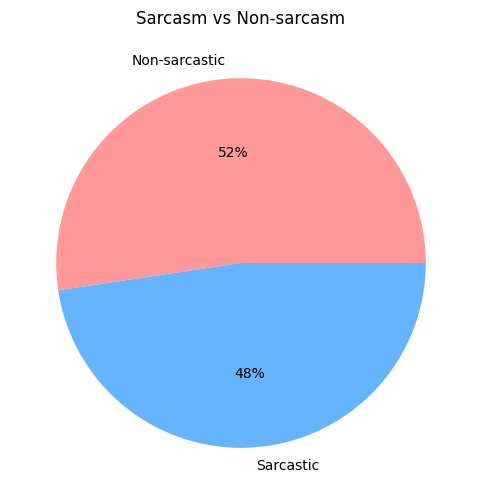

In [42]:
plt.figure(figsize=(8, 6))
# pie plot
plt.pie(df['is_sarcastic'].value_counts(), labels=['Non-sarcastic', 'Sarcastic'], autopct='%1.0f%%', colors=['#ff9999', '#66b3ff'])
plt.title('Sarcasm vs Non-sarcasm')
plt.show()

Looks great! classification is pretty balanced, so we don't need to worry about that. Let's take a look at the data.

## Preprocessing

In [26]:
df.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [43]:
nltk.download('stopwords')

# Assuming 'df' is your DataFrame

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming (using Porter Stemmer)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # Rejoin tokens into a single string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text
df['processed_headline'] = df['headline'].apply(lambda x: preprocess_text(x))

# Display the DataFrame with the processed headline column
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zhafar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,is_sarcastic,headline,article_link,processed_headline
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,thirtysometh scientist unveil doomsday clock h...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,dem rep total nail congress fall short gender ...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,eat veggi delici differ recip
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,inclement weather prevent liar get work
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,mother come pretti close use word stream corre...


## Feature Extraction

In [28]:
# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['processed_headline'])
y = df['is_sarcastic']


In [29]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [30]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [45]:
y_pred = model.predict(X_test)
print(y_pred[:10])

[1 1 1 0 1 0 0 0 1 1]


## Evaluate

In [39]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[2424,  509],
       [ 729, 2062]], dtype=int64)

In [32]:
# evaluate
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80      2933
           1       0.80      0.74      0.77      2791

    accuracy                           0.78      5724
   macro avg       0.79      0.78      0.78      5724
weighted avg       0.78      0.78      0.78      5724

0.783717679944095


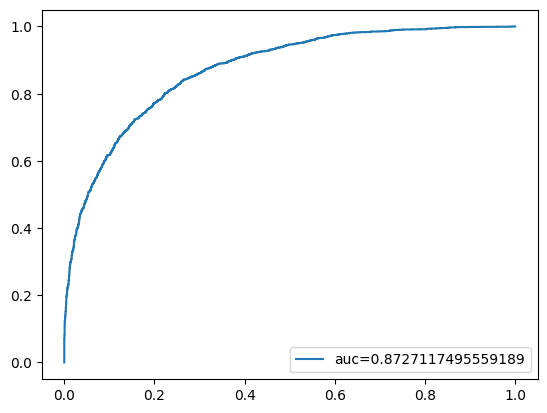

In [46]:
# ROC Curve
y_pred_proba = model.predict_proba(X_test)[::, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [33]:
# Create predict one function
def predict_one(text):
    # Preprocess the text
    preprocessed_text = preprocess_text(text)

    # Vectorize the preprocessed text
    vectorized_text = vectorizer.transform([preprocessed_text])

    # Make a prediction
    prediction = model.predict(vectorized_text)

    # Return the prediction
    return prediction[0]
# test predict one function


In [34]:
# Test the predict_one function with an example text
example_text = "New Study Reveals That Sleeping Eight Hours a Day Makes You Well-Rested"
prediction_result = predict_one(example_text)

# Print the result
print(f'Text: {example_text}')
print(f'Prediction: {prediction_result}')

Text: New Study Reveals That Sleeping Eight Hours a Day Makes You Well-Rested
Prediction: 1


In [35]:
# Test the predict_one function with an example text
example_text = "Health Officials Launch Campaign to Promote Vaccination Awareness"
prediction_result = predict_one(example_text)

# Print the result
print(f'Text: {example_text}')
print(f'Prediction: {prediction_result}')

Text: Health Officials Launch Campaign to Promote Vaccination Awareness
Prediction: 0
